In [2]:
from time import perf_counter
import numpy as np,os
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, power_transform, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.utils import shuffle
from sklearn.metrics import matthews_corrcoef, precision_recall_curve, auc, accuracy_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours, TomekLinks
from imblearn.pipeline import make_pipeline, Pipeline
import seaborn as sns,matplotlib.pyplot as plt

from library.configs import CLFS, IMBS, CV, SCORERS
from library.utils import evaluate, read_data

In [3]:
DATASETS = ['groovy-1_5_7.csv','jruby-1.4.0.csv','lucene-2.9.0.csv','jruby-1.7.0.preview1.csv','groovy-1_6_BETA_1.csv',
        'derby-10.2.1.6.csv','wicket-1.5.3.csv','camel-2.9.0.csv','camel-1.4.0.csv','activemq-5.8.0.csv']
#DATASETS = [f for f in os.listdir("JIRA/") if 'csv' in f]
len(DATASETS)

10

In [4]:
NOISE_TYPES = ['No','FN-Only','FP-Only','Both']
CV = RepeatedStratifiedKFold(n_splits=5,n_repeats=2,random_state=99)

In [5]:
models = {}
for im,samp in IMBS.items():
    for c,clf in CLFS.items():
        models[(im,c)] = Pipeline([('samp',samp),('clf',clf)])
models.keys(),len(models)

(dict_keys([('smote', 'dt'), ('smote', 'lr'), ('smote', 'nb'), ('smote', 'svm'), ('smote', 'knn'), ('smote', 'rf'), ('rus', 'dt'), ('rus', 'lr'), ('rus', 'nb'), ('rus', 'svm'), ('rus', 'knn'), ('rus', 'rf'), ('wilson', 'dt'), ('wilson', 'lr'), ('wilson', 'nb'), ('wilson', 'svm'), ('wilson', 'knn'), ('wilson', 'rf'), ('tomek', 'dt'), ('tomek', 'lr'), ('tomek', 'nb'), ('tomek', 'svm'), ('tomek', 'knn'), ('tomek', 'rf'), ('None', 'dt'), ('None', 'lr'), ('None', 'nb'), ('None', 'svm'), ('None', 'knn'), ('None', 'rf')]),
 30)

In [ ]:
cols = pd.MultiIndex.from_product([NOISE_TYPES,IMBS.keys(),CLFS.keys(),[f.__name__ for f in SCORERS]],names=['noise','imb','clf','metric'])
df = pd.DataFrame(index=DATASETS,columns=cols)

In [ ]:
from sklearn.metrics import confusion_matrix
FRACS = [0,.25,.5,.75,1.0]
cols = pd.MultiIndex.from_product([FRACS,IMBS.keys(),CLFS.keys(),[f.__name__ for f in SCORERS]],names=['frac','imb','clf','metric'])
df = pd.DataFrame(index=DATASETS,columns=cols)
for it,d in enumerate(DATASETS):
    X,y_noisy,y_real = read_data(d,stats=True)
    C = np.argwhere(y_real==1).ravel()
    N = np.argwhere(y_noisy==0).ravel()  #FP
    idx = np.intersect1d(N,C)
    tn, fp, fn, tp = confusion_matrix(y_real,y_noisy).ravel()
    print("idx:",len(idx),fn,len(N),len(C))
    for frac in FRACS:
        print("frac:",frac)
        y = y_noisy.copy()
        size = int(frac*len(idx))
        to_correct = np.random.choice(idx.copy(),size=size,replace=False)
        y[to_correct] = 1
        print(len(idx),len(to_correct))
        print(f"{precision_score(y_real,y):.3f},{recall_score(y_real,y):.3f}",(y_real!=y).sum())
        
        for k in models:
            r = evaluate(models[k],X,y,y_real,CV,SCORERS)
            for f in r:
                df.loc[d,(frac,k[0],k[1],f)] = r[f].mean()
    df.to_csv("FN.csv")

In [ ]:
from sklearn.metrics import confusion_matrix
FRACS = [0,.25,.5,.75,1.0]
cols = pd.MultiIndex.from_product([FRACS,IMBS.keys(),CLFS.keys(),[f.__name__ for f in SCORERS]],names=['frac','imb','clf','metric'])
df = pd.DataFrame(index=DATASETS,columns=cols)
for it,d in enumerate(DATASETS):
    X,y_noisy,y_real = read_data(d,stats=True)
    C = np.argwhere(y_real==0).ravel()
    N = np.argwhere(y_noisy==1).ravel()  #FP
    idx = np.intersect1d(N,C)
    tn, fp, fn, tp = confusion_matrix(y_real,y_noisy).ravel()
    print("idx:",len(idx),fn,len(N),len(C))
    for frac in FRACS:
        print("frac:",frac)
        y = y_noisy.copy()
        size = int(frac*len(idx))
        to_correct = np.random.choice(idx.copy(),size=size,replace=False)
        y[to_correct] = 0
        print(len(idx),len(to_correct))
        print(f"{precision_score(y_real,y):.3f},{recall_score(y_real,y):.3f}",(y_real!=y).sum())
        
        for k in models:
            r = evaluate(models[k],X,y,y_real,CV,SCORERS)
            for f in r:
                df.loc[d,(frac,k[0],k[1],f)] = r[f].mean()
    df.to_csv("FP.csv")

## Analysis

In [6]:
import numpy as np
import pandas as pd,os
from scipy.stats import wilcoxon, friedmanchisquare, rankdata, trim_mean, linregress
import scikit_posthocs as sp
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
FN = pd.read_csv("FN.csv",header=[0,1,2,3],index_col=0)
FP = pd.read_csv("FP.csv",header=[0,1,2,3],index_col=0)

In [11]:
FN = FN.drop(columns=['pr_rec_score'],level=3,axis=1).droplevel(3,axis=1)
FP = FP.drop(columns=['pr_rec_score'],level=3,axis=1).droplevel(3,axis=1)
FP.shape,FN.shape

((10, 150), (10, 150))

In [12]:
FRACS = [0.,.25,.5,.75,1.0]
fn,fp = {},{}
for c in FRACS:
    fn[c] = trim_mean(FN[str(c)].values.reshape(-1),.05)
    fp[c] = trim_mean(FP[str(c)].values.reshape(-1),.05)
    print(c)

0.0
0.25
0.5
0.75
1.0


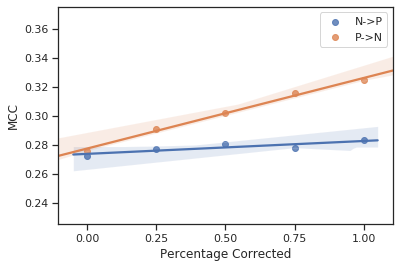

In [13]:
X = list(fp.keys())
plt.ylim(.225,.375)
plt.xticks(FRACS)
sns.regplot(X,list(fp.values()),ci=99,label='N->P');
sns.regplot(X,list(fn.values()),ci=99,label='P->N');
plt.legend();
plt.ylabel("MCC")
plt.xlabel("Percentage Corrected")
plt.savefig('figures/NPvsPN.pdf',format='pdf')

In [14]:
linregress(X,list(fn.values()))

LinregressResult(slope=0.04865858225914928, intercept=0.27729183063530505, rvalue=0.9970888720130039, pvalue=0.00018846732778494157, stderr=0.002148296890671084)

In [15]:
linregress(X,list(fp.values()))

LinregressResult(slope=0.008885875872038552, intercept=0.27359142423900773, rvalue=0.8792819611881367, pvalue=0.04942737432884706, stderr=0.002779031756172864)